In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import re
import preprocessor as p
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:0.2f}'.format

In [3]:
# FX過去のデータ
df = pd.read_csv("FX_MA_5days.csv")
df.head()

,time,open,high,low,close,5mean,target
0,2019-01-08 07:00:00,108.72,109.09,108.44,108.73,108.50,0
1,2019-01-09 07:00:00,108.75,109.01,107.97,108.16,108.36,0
2,2019-01-10 07:00:00,108.14,108.52,107.77,108.43,108.51,1
3,2019-01-11 07:00:00,108.43,108.60,108.15,108.51,108.51,0
4,2019-01-14 07:00:00,108.56,108.57,107.99,108.16,108.40,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
time      240 non-null object
open      240 non-null float64
high      240 non-null float64
low       240 non-null float64
close     240 non-null float64
5mean     240 non-null float64
target    240 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.2+ KB


In [5]:
df['target'].value_counts()

1    127
0    113
Name: target, dtype: int64

In [6]:
# 時間表記スライシング
def timechange(time):
    time = "".join(str(time)[:10])
    return time

In [7]:
df['time'] = df['time'].apply(lambda x: timechange(x))
df = df.rename(columns={'time':'date'})
df.head()

,date,open,high,low,close,5mean,target
0,2019-01-08,108.72,109.09,108.44,108.73,108.50,0
1,2019-01-09,108.75,109.01,107.97,108.16,108.36,0
2,2019-01-10,108.14,108.52,107.77,108.43,108.51,1
3,2019-01-11,108.43,108.60,108.15,108.51,108.51,0
4,2019-01-14,108.56,108.57,107.99,108.16,108.40,0


In [8]:
#　Twitterデータ取得
tweet = pd.read_csv('../NLP/trumptweep.csv')
del tweet['Unnamed: 0']
tweet.head()

,date,tweet
0,2019-07-14,"https://t.co/YaiCXrxYQq .....Sorry, can’t let..."
1,2019-07-15,"The Obama Administration built the Cages, not..."
2,2019-07-16,Looking forward to tomorrow night’s rally in ...
3,2019-07-17,The United States House of Representatives ha...
4,2019-07-18,This should have been taken care of years ago...


In [9]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
date     132 non-null object
tweet    132 non-null object
dtypes: object(2)
memory usage: 2.2+ KB


In [10]:
#　右にJoinする
data = pd.merge(df, tweet, on='date', how='right')
data = data.dropna()
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,"The Obama Administration built the Cages, not..."
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,Looking forward to tomorrow night’s rally in ...
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,The United States House of Representatives ha...
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,This should have been taken care of years ago...
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,RT @mike_pence: When our President stands up ...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 8 columns):
date      103 non-null object
open      103 non-null float64
high      103 non-null float64
low       103 non-null float64
close     103 non-null float64
5mean     103 non-null float64
target    103 non-null float64
tweet     103 non-null object
dtypes: float64(6), object(2)
memory usage: 7.2+ KB


In [12]:
def remove_punctuation(text):
    no_punc = "".join([x for x in text if x not in string.punctuation])
    return no_punc

In [13]:
data['tweet'] = data['tweet'].apply(lambda x: remove_punctuation(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,The Obama Administration built the Cages not ...
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,Looking forward to tomorrow night’s rally in ...
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,The United States House of Representatives ha...
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,This should have been taken care of years ago...
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,RT mikepence When our President stands up to ...


In [14]:
# instantiate tokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['tweet'] = data['tweet'].apply(lambda x: tokenizer.tokenize(x.lower()))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,"[the, obama, administration, built, the, cages..."
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,"[looking, forward, to, tomorrow, night, s, ral..."
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,"[the, united, states, house, of, representativ..."
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,"[this, should, have, been, taken, care, of, ye..."
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,"[rt, mikepence, when, our, president, stands, ..."


In [15]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [16]:
data['tweet'] = data['tweet'].apply(lambda x: remove_stopwords(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,"[obama, administration, built, cages, trump, a..."
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,"[looking, forward, tomorrow, night, rally, gre..."
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,"[united, states, house, representatives, overw..."
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,"[taken, care, years, ago, trump, administratio..."
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,"[rt, mikepence, president, stands, radical, de..."


In [17]:
# instantiate lemmatizer
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(x) for x in text]
    return lem_text

In [18]:
data['tweet'] = data['tweet'].apply(lambda x: word_lemmatizer(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,"[obama, administration, built, cage, trump, ad..."
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,"[looking, forward, tomorrow, night, rally, gre..."
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,"[united, state, house, representative, overwhe..."
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,"[taken, care, year, ago, trump, administration..."
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,"[rt, mikepence, president, stand, radical, dem..."


In [19]:
# instantiate stemmer
stemmer = PorterStemmer()
def word_stemmer(text):
    stem_txt = " ".join([stemmer.stem(x) for x in text])
    return stem_txt

In [20]:
data['tweet'] = data['tweet'].apply(lambda x: word_stemmer(x))
data.head()

,date,open,high,low,close,5mean,target,tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,obama administr built cage trump administr dem...
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,unit state hous repres overwhelmingli vote kil...
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,taken care year ago trump administr take care ...
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,rt mikep presid stand radic democrat accus bor...


In [21]:
def include_bag(text):
    boolean = False
    # bagのデータを取得
    FX_word = pd.read_csv('../NLP/bag_of_words.csv')
    FX_word['word'] = FX_word['Unnamed: 0']
    del FX_word['Unnamed: 0']
    #　意図的にFXで使用する単語のリストを追加する
    new = ['japan', 'usd', 'jpy', 'abe', 'doller', 'yen', 'fx']
    fx_word = list(FX_word.word) + new
    #　文章にbagの単語があればTrueなければFalesを返す
    text = text.split()
    for x in range(len(text)):
        if text[x] in fx_word:
            boolean = True
    return boolean

In [22]:
data['FX_word'] = data['tweet'].apply(lambda x: include_bag(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,obama administr built cage trump administr dem...,False
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...,False
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,unit state hous repres overwhelmingli vote kil...,False
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,taken care year ago trump administr take care ...,False
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,rt mikep presid stand radic democrat accus bor...,False


In [23]:
def pos_check(text):
    sid = SIA()
    ss = sid.polarity_scores(text)
    return ss['pos']

In [24]:
data['pos'] = data['tweet'].apply(lambda x: pos_check(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,obama administr built cage trump administr dem...,False,0.10
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...,False,0.09
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,unit state hous repres overwhelmingli vote kil...,False,0.12
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,taken care year ago trump administr take care ...,False,0.17
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,rt mikep presid stand radic democrat accus bor...,False,0.16


In [25]:
def neg_check(text):
    sid = SIA()
    ss = sid.polarity_scores(text)
    return ss['neg']

In [26]:
data['neg'] = data['tweet'].apply(lambda x: neg_check(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,obama administr built cage trump administr dem...,False,0.10,0.15
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...,False,0.09,0.22
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,unit state hous repres overwhelmingli vote kil...,False,0.12,0.18
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,taken care year ago trump administr take care ...,False,0.17,0.04
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,rt mikep presid stand radic democrat accus bor...,False,0.16,0.10


In [27]:
def neu_check(text):
    sid = SIA()
    ss = sid.polarity_scores(text)
    return ss['neu']

In [28]:
data['neu'] = data['tweet'].apply(lambda x: neu_check(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg,neu
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,obama administr built cage trump administr dem...,False,0.10,0.15,0.75
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...,False,0.09,0.22,0.69
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,unit state hous repres overwhelmingli vote kil...,False,0.12,0.18,0.70
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,taken care year ago trump administr take care ...,False,0.17,0.04,0.79
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,rt mikep presid stand radic democrat accus bor...,False,0.16,0.10,0.75


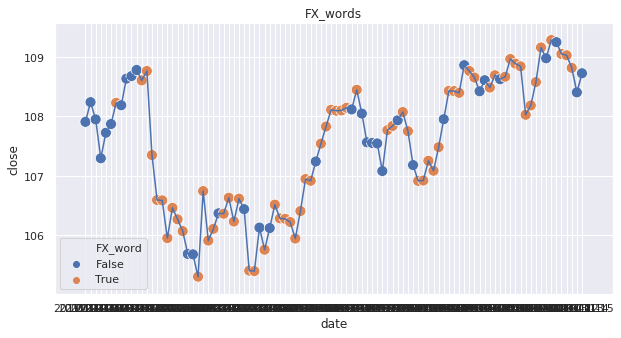

In [29]:
sns.set()
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data['date'], data['close']).set_title("FX_words")
sns.scatterplot(data['date'], data['close'],s = 120, hue=data['FX_word'])

In [30]:
senti = []
for i in range(len(data)):
    senti_tweet = 'neu_tweet'
    if data.iloc[i]['pos'] >= 0.2 and data.iloc[i]['pos'] > data.iloc[i]['neg']:
        senti_tweet = 'pos_tweet'
    elif data.iloc[i]['neg'] >= 0.18 and data.iloc[i]['pos'] < data.iloc[i]['neg']:
        senti_tweet = 'neg_tweet'
    senti.append(senti_tweet)

In [31]:
data['senti_tweet'] = senti
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg,neu,senti_tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,0.00,obama administr built cage trump administr dem...,False,0.10,0.15,0.75,neu_tweet
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...,False,0.09,0.22,0.69,neg_tweet
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,0.00,unit state hous repres overwhelmingli vote kil...,False,0.12,0.18,0.70,neu_tweet
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,0.00,taken care year ago trump administr take care ...,False,0.17,0.04,0.79,neu_tweet
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,0.00,rt mikep presid stand radic democrat accus bor...,False,0.16,0.10,0.75,neu_tweet


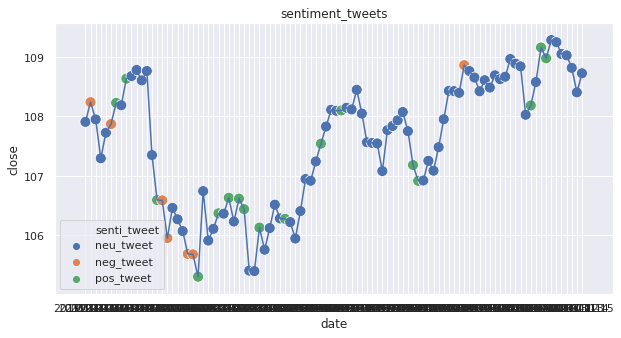

In [32]:
sns.set()
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data['date'], data['close']).set_title("sentiment_tweets")
sns.scatterplot(data['date'], data['close'],s = 120, hue=data['senti_tweet'])
fig.savefig('FX_sentiment_tweet.png')

In [33]:
# ここでTweetの感情を基準にラベルを変えている
data['target'][data['senti_tweet'] == 'pos_tweet'] = 2.00
data['target'][data['senti_tweet'] == 'neu_tweet'] = 1.00
data['target'][data['senti_tweet'] == 'neg_tweet'] = 0.00
data['target'].value_counts()

/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1.00    79
2.00    17
0.00     7
Name: target, dtype: int64

In [34]:
def FX_words_to_number(boolean):
    if boolean == True:   # FXの言葉が含まれている
        return 0.00
    else:   # FXの言葉が含まれていない
        return 1.00

In [35]:
def senti_tweets_to_cotegori(categori):
    if categori == "pos_tweet":   #肯定的Tweet
        return 0.00
    elif categori == "neu_tweet":    #普通Tweet
        return 1.00
    else:    #否定的Tweet
        return 2.00

In [36]:
#　前処理　＋　データを数字化
#tweets = data['tweet']
#del data['tweet']
data['FX_word'] = data['FX_word'].apply(lambda x: FX_words_to_number(x))
data['senti_tweet'] = data['senti_tweet'].apply(lambda x: senti_tweets_to_cotegori(x))
data.head()

,date,open,high,low,close,5mean,target,tweet,FX_word,pos,neg,neu,senti_tweet
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,1.00,obama administr built cage trump administr dem...,1.00,0.10,0.15,0.75,1.00
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,0.00,look forward tomorrow night ralli greenvil nor...,1.00,0.09,0.22,0.69,2.00
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,1.00,unit state hous repres overwhelmingli vote kil...,1.00,0.12,0.18,0.70,1.00
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,1.00,taken care year ago trump administr take care ...,1.00,0.17,0.04,0.79,1.00
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,1.00,rt mikep presid stand radic democrat accus bor...,1.00,0.16,0.10,0.75,1.00


In [37]:
# columnの並び替え
data = data.ix[:, ['date','open','high','low','close','5mean',
            'FX_word','pos','neg','neu','senti_tweet','target']]
data.head()

/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,date,open,high,low,close,5mean,FX_word,pos,neg,neu,senti_tweet,target
0,2019-07-15,107.92,108.11,107.80,107.91,108.14,1.00,0.10,0.15,0.75,1.00,1.00
1,2019-07-16,107.91,108.38,107.82,108.24,108.09,1.00,0.09,0.22,0.69,2.00,0.00
2,2019-07-17,108.24,108.33,107.94,107.95,107.98,1.00,0.12,0.18,0.70,1.00,1.00
3,2019-07-18,107.99,108.02,107.21,107.30,107.86,1.00,0.17,0.04,0.79,1.00,1.00
4,2019-07-19,107.30,107.98,107.22,107.73,107.82,1.00,0.16,0.10,0.75,1.00,1.00


In [38]:
#　全体を8:2で等割
split_data = '2019-10-25'
train, test = data[data['date'] < split_data], data[data['date'] >= split_data]

In [39]:
train = train.set_index('date')
test = test.set_index('date')

In [40]:
X_train = train.iloc[:,:-6]
Y_train = train['target']

X_test = test.iloc[:,:-6]
Y_test = test['target']

In [41]:
X_train = X_train.as_matrix()
print("Data len: ",len(X_train))

X_test = X_test.as_matrix()
print("Data len: ",len(X_test))

# 正規化
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)

ms = MinMaxScaler()
X_test = ms.fit_transform(X_test)

Data len:  82
Data len:  21


/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [42]:
Y_train = np.array(Y_train, dtype=np.int64)
print("Y_train Target len: ",len(Y_train))

Y_test = np.array(Y_test, dtype=np.int64)
print("Y_train Target len: ",len(Y_test))

Y_train Target len:  82
Y_train Target len:  21


In [43]:
maxlen = 5
dataTrain = []
targetTrain = []
for i in range(0, len(X_train) - maxlen):
    dataTrain.append(X_train[i: i + maxlen])
    targetTrain.append(Y_train[i + maxlen])

dataTest = []
targetTest = []
for i in range(0, len(X_test) - maxlen):
    dataTest.append(X_test[i: i + maxlen])
    targetTest.append(Y_test[i + maxlen])

In [44]:
X_train = np.array(dataTrain)
Y_train = np.array(targetTrain)

X_test = np.array(dataTest)
Y_test = np.array(targetTest)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(77, 5, 5)
(77,)
(16, 5, 5)
(16,)


In [45]:
#Y_train = Y_train.reshape(len(Y_train), 1)
#Y_test = Y_test.reshape(len(Y_test), 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [46]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(77, 5, 5)
(77, 3)
(16, 5, 5)
(16, 3)


In [47]:
'''
モデル設定
'''
length_of_sequence = X_train.shape[1]  # 入力層 = 5
out_neurons = 3                        # 出力層 = 3
n_hidden = 64                          # 隠れ層 = 100

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, 5), return_sequences=False))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(out_neurons))
model.add(Activation("softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, metrics=['acc'])

In [49]:
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
__________

In [50]:
# コールバック指定（https://qiita.com/yukiB/items/f45f0f71bc9739830002）
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='auto', patience=20)
history = model.fit(X_train, Y_train,
                  batch_size = 1, # 論文で使われるのが1, 32, 128, 256, 512
                  epochs=200,
                  validation_split=0.2,
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 2s 27ms/step - loss: 0.9651 - acc: 0.6721 - val_loss: 0.4550 - val_acc: 0.9375
Epoch 2/200
61/61 [==============================] - 0s 5ms/step - loss: 0.8184 - acc: 0.6885 - val_loss: 0.4195 - val_acc: 0.9375
Epoch 3/200
61/61 [==============================] - 0s 5ms/step - loss: 0.8925 - acc: 0.6885 - val_loss: 0.4491 - val_acc: 0.9375
Epoch 4/200
61/61 [==============================] - 0s 5ms/step - loss: 0.8527 - acc: 0.6885 - val_loss: 0.4911 - val_acc: 0.9375
Epoch 5/200
61/61 [==============================] - 0s 5ms/step - loss: 0.8506 - acc: 0.6885 - val_loss: 0.5196 - val_acc: 0.9375
Epoch 6/200
61/61 [==============================] - 0s 5ms/step - loss: 0.8465 - acc: 0.6885 - val_loss: 0.5211 - val_acc: 0.9375
Epoch 7/200
61/61 [==============================] - 0s 5ms/step - loss: 0.

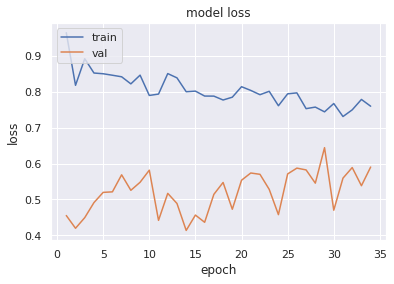

In [51]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('FinalMA5loss.png')
plt.show()

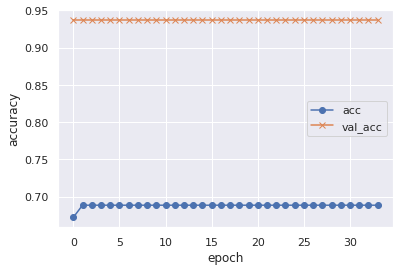

In [52]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.savefig('FinalMA5acc.png')
plt.show()

In [53]:
print("Test accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

16/16 [==============================] - 0s 441us/step
Test accuracy: 0.8125
